Lecturer: Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Ziwei Huang, Rita González Márquez

Summer term 2023

Name: FILL IN YOUR NAMES HERE

# Neural Data Science Project 01

## Working with Calcium data

In the following project you will recieve a data set, along with a set of questions. Use the methods that you have learned throughout this course to explore the data and to answer the questions. You are free to use tools, resources and libraries as you see fit. Use comments and markdown cells to document your thought process and to explain your reasoning. We encourage you to compare different algorithms or to implement state of the art solutions. The notebook should be self contained, although you may offload some functions to a `utils.py`. The notebook should be concluded with a final summary / conclusions section.

In [2]:
# import packages here
import os

import utils_project1 as utils

import numpy as np
import pandas as pd
import jupyter_black
import matplotlib.pyplot as plt
import matplotlib.patches as mp

jupyter_black.load()

## Context
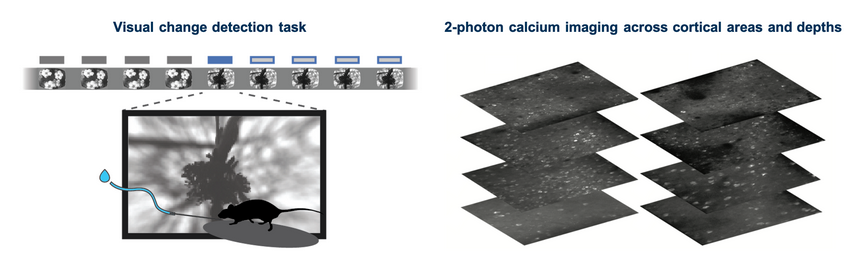

The data set that goes along with this notebook was recorded using in vivo 2-photon calcium imaging to measure the activity of genetically identified neurons in the visual cortex of mice performing a go/no-go visual change detection task. The data recordings stem from primary visual cortex and a GCaMP6f indicator was used. The data was recorded as follows.

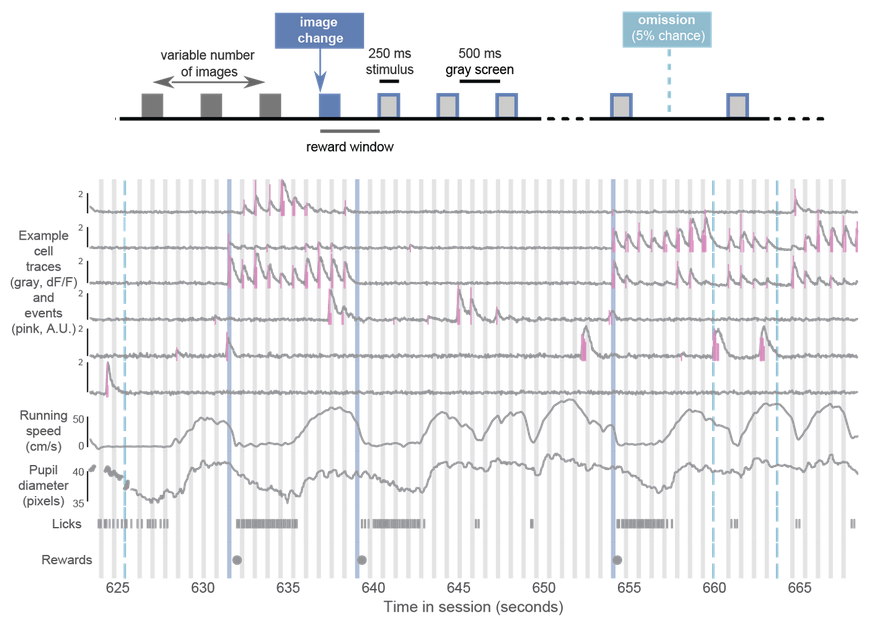

The data consists of:
- the preprocessed activity traces (df/f)
- the stimulus metadata
- the ROI masks for each cell
- a maximum activity projection of all ROIs
- running speed
- table of stimulus epochs

You will only work with a drifting grating stimulus.

Since the experiments were performed in sequence the calcium recordings that you receive also contain some other stimulus modalities (see `data["stim_epoch_table"]`). You can ignore these sections of the time-series data during analysis. Not all the data provided has to be used, however it can be incorporated into your analysis.

In [3]:
# load data
def load_data(path="."):
    def array2df(d, key, cols):
        d[key] = pd.DataFrame(d[key], columns=cols)

    data = np.load(path + "/dff_data_dsi.npz", allow_pickle=True)
    data = dict(data)
    array2df(
        data,
        "stim_table",
        ["temporal_frequency", "orientation", "blank_sweep", "start", "end"],
    )
    array2df(data, "stim_epoch_table", ["stimulus", "start", "end"])

    return data


def print_info(data):
    data_iter = ((k, type(v), v.shape) for k, v in data.items())
    l = [f"[{k}] - {t}, - {s}" for k, t, s in data_iter]
    print("\n".join(l) + "\n")


data = load_data(path="../data/")
print(type(data))
print(data.keys())
print("Overview of the data")
print_info(data)
#
print(data["stim_epoch_table"])
print(data["stim_table"])
print(data["t"])

<class 'dict'>
dict_keys(['t', 'dff', 'stim_table', 'roi_masks', 'max_projection', 'running_speed', 'stim_epoch_table'])
Overview of the data
[t] - <class 'numpy.ndarray'>, - (115471,)
[dff] - <class 'numpy.ndarray'>, - (106, 115471)
[stim_table] - <class 'pandas.core.frame.DataFrame'>, - (628, 5)
[roi_masks] - <class 'numpy.ndarray'>, - (106, 512, 512)
[max_projection] - <class 'numpy.ndarray'>, - (512, 512)
[running_speed] - <class 'numpy.ndarray'>, - (2, 115471)
[stim_epoch_table] - <class 'pandas.core.frame.DataFrame'>, - (7, 3)

              stimulus  start     end
0    drifting_gratings    747   18775
1  natural_movie_three  19709   37767
2    natural_movie_one  38671   47699
3    drifting_gratings  48602   66630
4          spontaneous  66780   75697
5  natural_movie_three  75698   93756
6    drifting_gratings  94659  115215
     temporal_frequency  orientation  blank_sweep     start       end
0                   1.0        225.0          0.0     747.0     807.0
1               

# Downloading OOPSI alogrithm for the spike inference 
* Link to the Github repository: https://github.com/liubenyuan/py-oopsi
* Link to the paper: http://stat.columbia.edu/~liam/research/pubs/vogelstein-fast.pdf 
    * published in: Journal of Neurophysiology, 104(6): 3691-3704

In [4]:
download_url = "https://raw.githubusercontent.com/liubenyuan/py-oopsi/master/oopsi.py"
file_name = "oopsi.py"
if not os.path.exists(file_name):
    !curl -L $download_url -o $file_name

In [5]:
import oopsi as ops

# 1. Data Exploration 
* First look at distribution of the orientation of the drifting gratings.
* Display the maximum projection of the ROIs.
* Display the roi masks.

* Display the df/f traces over time maby normalized to the maximum value of the trace.
    * Visualize the traces where the drifting gratings were shown.


## The trials are not equally distributed with orientation 
* but over all trials we have aroung 75 trials for each orientation and 30 trials for the blank stimulus

[  0.  45.  90. 135. 180. 225. 270. 315.  nan] [75 75 75 74 75 75 75 74 30]
[ 1.  2.  4.  8. 15. nan] [120 120 119 120 119  30]
[0. 1.] [598  30]


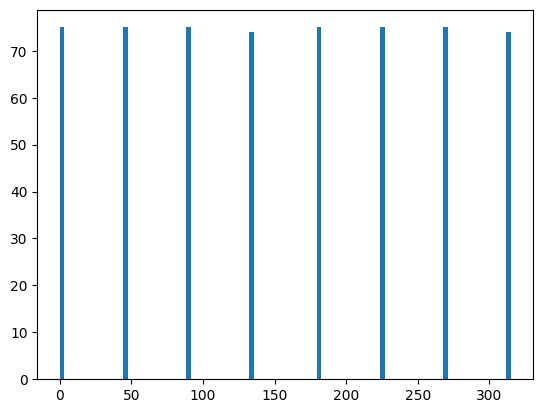

In [6]:
plt.hist(data["stim_table"]["orientation"], bins=100)
uniq, coutnts = np.unique(data["stim_table"]["orientation"], return_counts=True)
print(uniq, coutnts)
freqs, counts_freqs = np.unique(
    data["stim_table"]["temporal_frequency"], return_counts=True
)
print(freqs, counts_freqs)
blanks, counts_blanks = np.unique(data["stim_table"]["blank_sweep"], return_counts=True)
print(blanks, counts_blanks)

## Not equally distributed over the three trials!

In [7]:
uniq, coutnts = np.unique(
    data["stim_table"]["orientation"][:200],
    return_counts=True,
)

print(uniq, coutnts)

uniq, coutnts = np.unique(
    data["stim_table"]["orientation"][200:400],
    return_counts=True,
)
print(uniq, coutnts)

uniq, coutnts = np.unique(
    data["stim_table"]["orientation"][400:627],
    return_counts=True,
)
print(uniq, coutnts)

[  0.  45.  90. 135. 180. 225. 270. 315.  nan] [26 25 22 25 24 29 18 19 12]
[  0.  45.  90. 135. 180. 225. 270. 315.  nan] [23 26 19 22 21 22 28 27 12]
[  0.  45.  90. 135. 180. 225. 270. 315.  nan] [26 24 34 27 29 24 29 28  6]


## Time axis is around 30 hz (30 frames per second)!

In [8]:
print(1 / np.unique(np.diff(data["t"])))

[30.07518797 30.07518797 30.07518797 30.07518797 30.07518797 30.07518797
 30.07518797 30.07518797 30.07518797 30.07518797 30.07518797 30.06614552
 30.06614552 30.06614552 30.06614552 30.06614552 30.06614552 30.06614552
 30.06614552 30.06614552 30.06614552]


## Display the maximum projection of the ROIs, and the roi masks

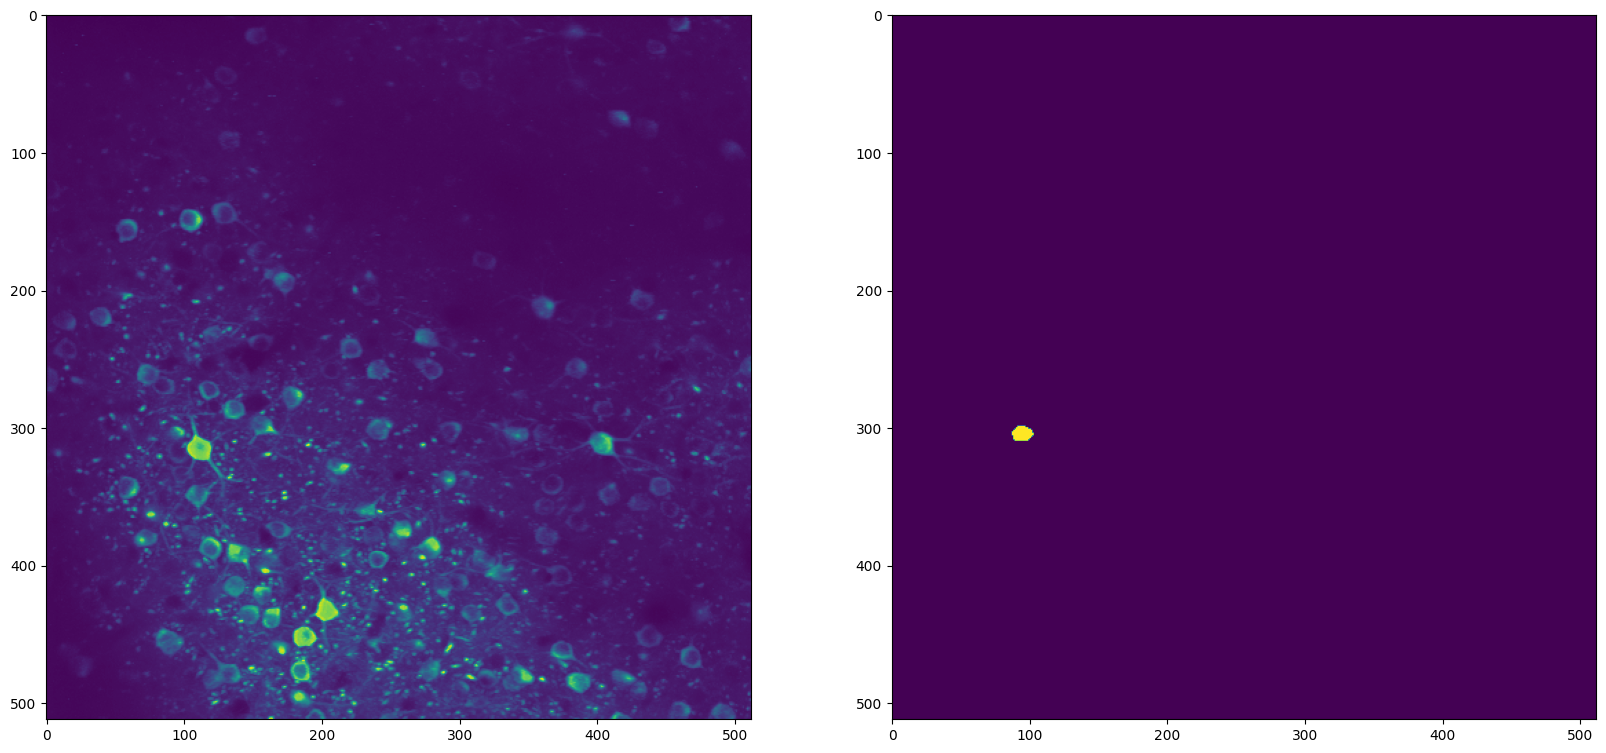

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(data["max_projection"])
ax[1].imshow(data["roi_masks"][0, :, :])

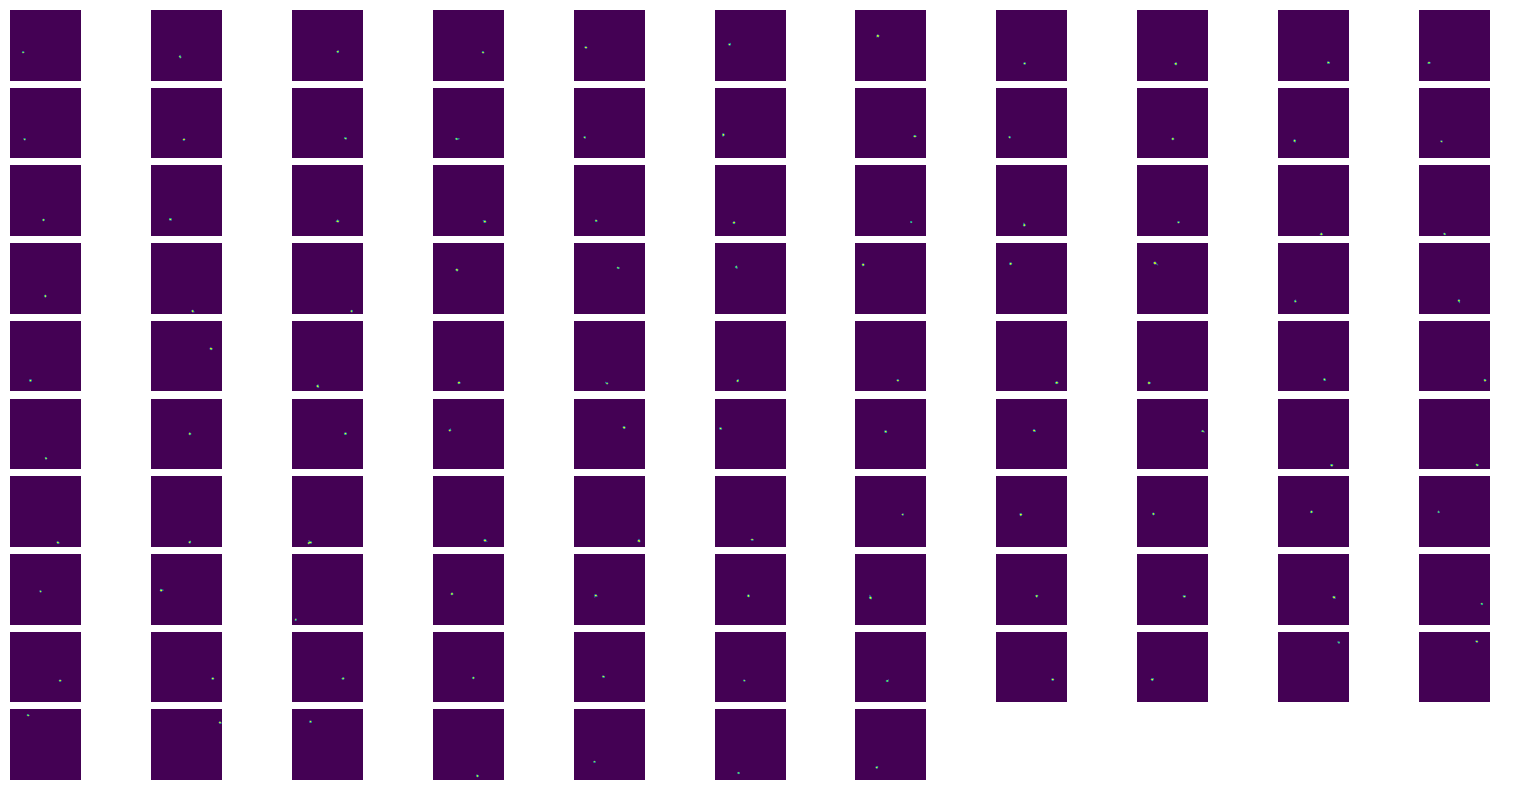

In [10]:
fig, axs = plt.subplots(10, 11, figsize=(20, 10))
plt.subplots_adjust(wspace=0, hspace=0.1)
for i, ax in enumerate(axs.flat):
    if i < 106:
        ax.imshow(data["roi_masks"][i, :, :])
    ax.axis("off")
plt.show()

## First look at all the calcium traces 
There are 106 different ROIs and to plot them nicely on top of each other we normalize them to the maximum value of the trace.

Text(0.09, 0.5, 'ROI #')

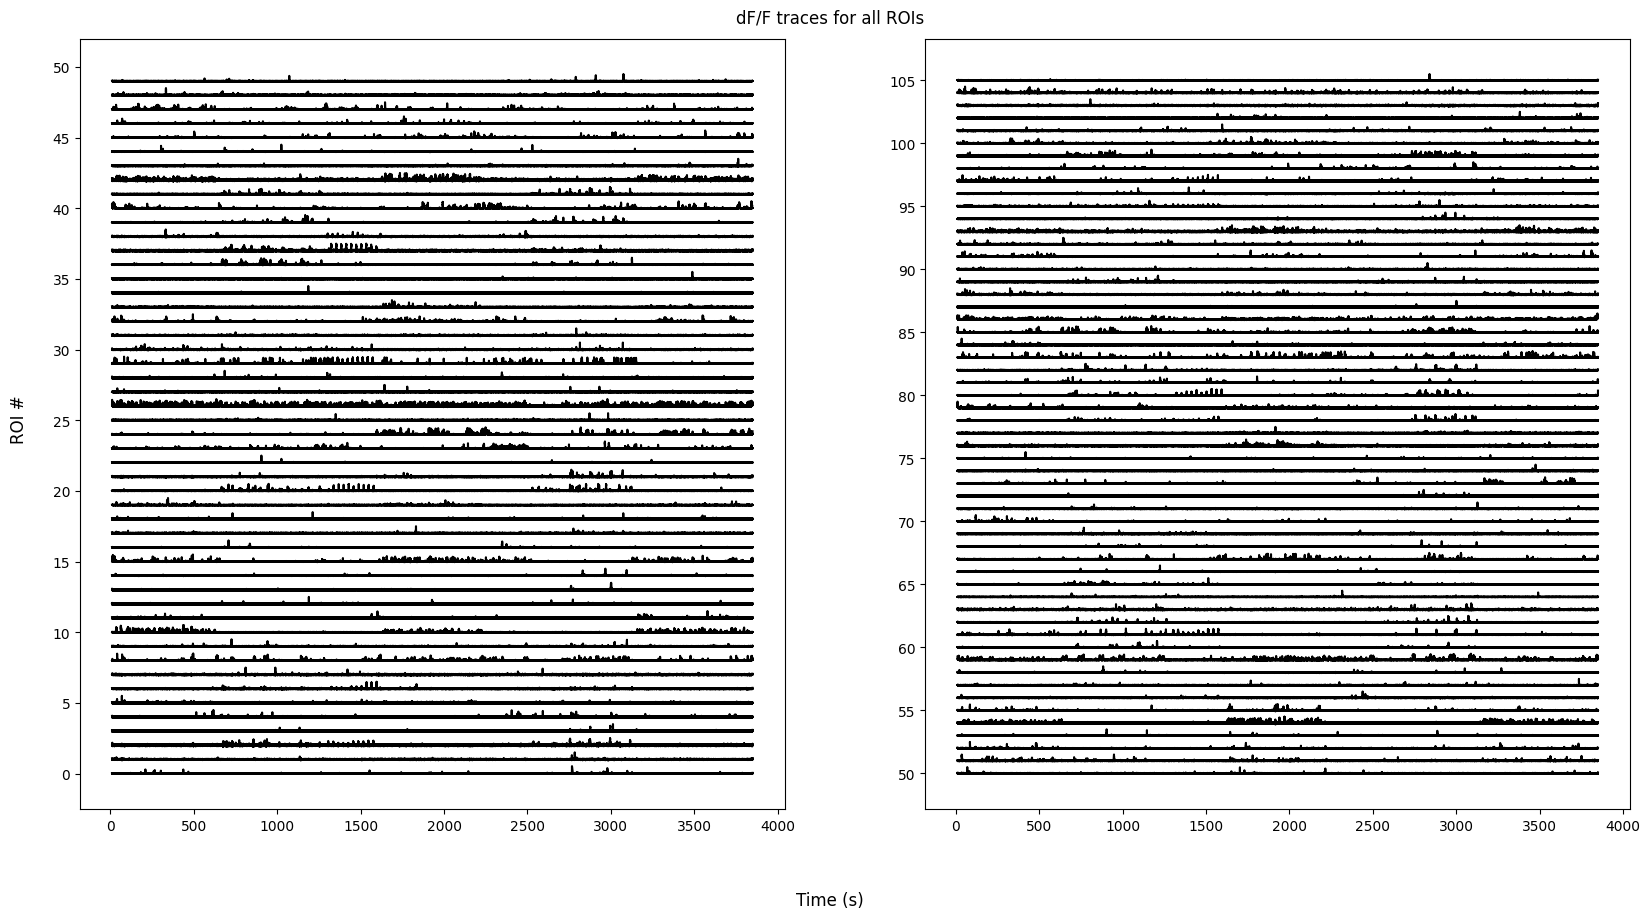

In [11]:
# plot dff traces into to subplots with the normalized dff values
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
for i in range(50):
    axs[0].plot(
        data["t"], (data["dff"][i, :] / np.max(data["dff"][i, :])) + i * 2, c="k"
    )
for i in range(50, 106):
    axs[1].plot(
        data["t"], (data["dff"][i, :] / np.max(data["dff"][i, :])) + i * 2, c="k"
    )
fig.supxlabel("Time (s)")
fig.supylabel("dF/F", x=0.09, y=0.5)

axs[0].set_yticks(np.arange(0, 101, 10))
axs[0].set_yticklabels(np.arange(0, 51, 5))
axs[1].set_yticks(np.arange(100, 212, 10))
axs[1].set_yticklabels(np.arange(50, 106, 5))
fig.suptitle(
    "dF/F traces for all ROIs",
    x=0.5,
    y=0.91,
)
fig.supylabel("ROI #", x=0.09, y=0.5)

## Visualize the traces where the drifting gratings were shown
For this we used the start and stop times in the stim_epoch_table. The added vertical lines indicate the start and stop times of the drifting gratings.

In [35]:
# get the start and end times of the drifting grating stimulus
stimulusOF = "drifting_gratings"
drifting_df = data["stim_epoch_table"]["stimulus"] == stimulusOF
start_times = data["stim_epoch_table"]["start"][drifting_df].to_numpy().astype(int)
end_times = data["stim_epoch_table"]["end"][drifting_df].to_numpy().astype(int)
print(data["t"][np.array(start_times)])
print(data["t"][np.array(end_times)])
print(data["t"][np.array(end_times)] - data["t"][np.array(start_times)])
print(
    data["t"][data["stim_table"]["end"][0].astype(int)]
    - data["t"][data["stim_table"]["start"][0].astype(int)]
)

[  34.51795 1625.90436 3157.53702]
[ 634.02188 2225.4245  3841.13976]
[599.50393 599.52014 683.60274]
1.9952200000000033


Text(0.09, 0.5, 'dF/F')

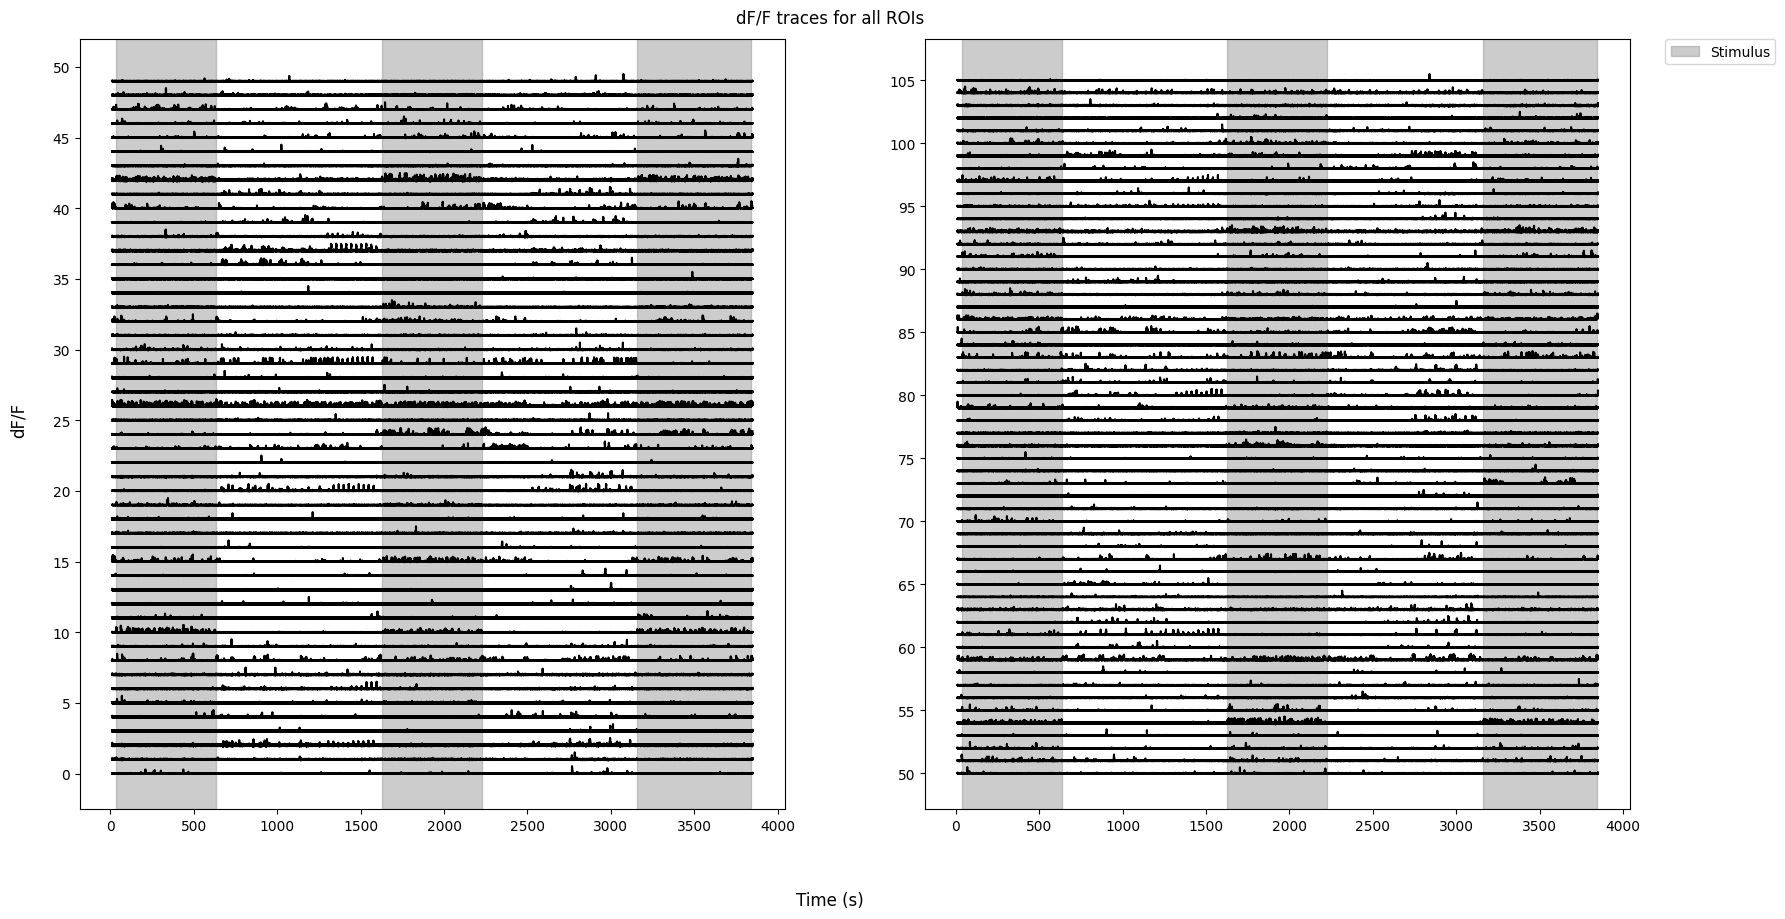

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
for i in range(50):
    axs[0].plot(
        data["t"], (data["dff"][i, :] / np.max(data["dff"][i, :])) + i * 2, c="k"
    )
for i in range(50, 106):
    axs[1].plot(
        data["t"], (data["dff"][i, :] / np.max(data["dff"][i, :])) + i * 2, c="k"
    )
# plot the start and end times of the stimulus as gray areas
for i, s in enumerate(start_times):
    axs[0].axvspan(data["t"][s], data["t"][end_times[i]], alpha=0.4, color="gray")
    if i == 0:
        axs[1].axvspan(
            data["t"][s],
            data["t"][end_times[i]],
            alpha=0.4,
            color="gray",
            label="Stimulus",
        )
    else:
        axs[1].axvspan(data["t"][s], data["t"][end_times[i]], alpha=0.4, color="gray")

axs[0].set_yticks(np.arange(0, 101, 10))
axs[0].set_yticklabels(np.arange(0, 51, 5))
axs[1].set_yticks(np.arange(100, 212, 10))
axs[1].set_yticklabels(np.arange(50, 106, 5))
axs[1].legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
fig.suptitle(
    "dF/F traces for all ROIs",
    x=0.5,
    y=0.91,
)
fig.supxlabel("Time (s)")
fig.supylabel("dF/F", x=0.09, y=0.5)

## Looking at some promissing cells, plotting the first trial:
* 10, 29, 54, because they show high activity during the drifting gratings in all 3 trials
* 10 is selective to orientation 45° and 225°
* we can estimate that cell 29 is selective to orientation 270°?
* cell 54 is selectivwe to orientation to 135° and 315°? 

In [44]:
colors_list = [
    "#271f7f",
    "#1565c0",
    "#009688",
    "#8bc34a",
    "#ffc107",
    "#ff9800",
    "#f44336",
    "#ad1457",
    "k",
]

In [175]:
%matplotlib qt6
orientations = np.sort(data["stim_table"]["orientation"].unique())
colors_orentation = np.zeros(len(data["stim_table"]["orientation"]), dtype=int)
for i, ori in enumerate(orientations):
    if i == 8:
        colors_orentation[data["stim_table"]["blank_sweep"] == 1] = i
    colors_orentation[data["stim_table"]["orientation"] == ori] = i

rois = [
    10,
    29,
    54,
]
fig, axs = plt.subplots(len(rois), figsize=(20, 20), sharex=True)
plt.subplots_adjust(hspace=0.2)

limits = [100, 800]
for i, roi in enumerate(rois):
    axs[i].plot(data["t"], data["dff"][roi], c="k")
    for indx, (s, e) in enumerate(
        zip(
            data["t"][np.array(data["stim_table"]["start"], dtype=int)],
            data["t"][np.array(data["stim_table"]["end"], dtype=int)],
        )
    ):
        axs[i].axvspan(
            s,
            e,
            alpha=0.6,
            color=colors_list[colors_orentation[indx]],
        )
    orientation_patches = [
        mp.Rectangle(
            (0, 0),
            1,
            1,
            fc=colors_list[i],
            alpha=0.6,
            angle=orientations[i],
        )
        for i in range(9)
    ]

    axs[i].set_xlim(limits)
    axs[i].set_title(f"ROI {roi}")
axs[i].set_xlabel("Time (s)")
fig.supylabel("dF/F", x=0.1, y=0.5)

axs[0].legend(
    orientation_patches,
    orientations,
    bbox_to_anchor=(0.2, 1.2),
    loc="center left",
    borderaxespad=-3,
    fontsize=12,
    title="Orientation \n (degrees)",
    title_fontsize=12,
    ncol=9,
)

## Can we already see orientation selectivity in the DF/F traces?

In [16]:
# mean calcium value for each orientation
orientations = data["stim_table"]["orientation"].unique()
orientations = orientations[~np.isnan(orientations)]
mean_calcium_orientation = np.zeros((data["dff"].shape[0], len(orientations)))
mean_calcium_orientation_baseline = np.zeros((data["dff"].shape[0], len(orientations)))
std_calcium_orientation = np.zeros((data["dff"].shape[0], len(orientations)))
std_calcium_orientation_baseline = np.zeros((data["dff"].shape[0], len(orientations)))
for i, orientation in enumerate(np.sort(orientations)):
    start_times = (
        data["stim_table"]["start"][data["stim_table"]["orientation"] == orientation]
        .to_numpy()
        .astype(int)
    )
    start_times_bs = (
        data["stim_table"]["start"][data["stim_table"]["blank_sweep"] == 1]
        .to_numpy()
        .astype(int)
    )

    end_times = (
        data["stim_table"]["end"][data["stim_table"]["orientation"] == orientation]
        .to_numpy()
        .astype(int)
    )
    end_times_bs = (
        data["stim_table"]["end"][data["stim_table"]["blank_sweep"] == 1]
        .to_numpy()
        .astype(int)
    )

    for roi in range(data["dff"].shape[0]):
        mean_calcium_orientation[roi, i] = np.mean(
            [np.mean(data["dff"][roi, s:e]) for s, e in zip(start_times, end_times)],
            axis=0,
        )
        mean_calcium_orientation_baseline[roi, i] = np.mean(
            [
                np.mean(data["dff"][roi, s:e])
                for s, e in zip(start_times_bs, end_times_bs)
            ],
            axis=0,
        )
        std_calcium_orientation[roi, i] = np.std(
            [np.mean(data["dff"][roi, s:e]) for s, e in zip(start_times, end_times)],
            axis=0,
        )
        std_calcium_orientation_baseline[roi, i] = np.std(
            [
                np.mean(data["dff"][roi, s:e])
                for s, e in zip(start_times_bs, end_times_bs)
            ],
            axis=0,
        )
print(mean_calcium_orientation.shape)

(106, 8)


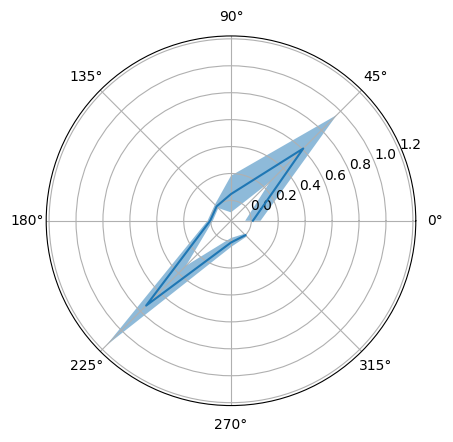

In [17]:
# plot a polar plot for for each orientation
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": "polar"})

roi = 10
ax.plot(
    np.deg2rad(
        np.sort(
            data["stim_table"]["orientation"].unique()[
                ~np.isnan(data["stim_table"]["orientation"].unique())
            ]
        )
    ),
    mean_calcium_orientation[roi, :],
)
ax.fill_between(
    np.deg2rad(
        np.sort(
            data["stim_table"]["orientation"].unique()[
                ~np.isnan(data["stim_table"]["orientation"].unique())
            ]
        )
    ),
    mean_calcium_orientation[roi, :] - std_calcium_orientation[roi, :],
    mean_calcium_orientation[roi, :] + std_calcium_orientation[roi, :],
    alpha=0.5,
)
# ax.plot(
#     np.deg2rad(
#         np.sort(
#             data["stim_table"]["orientation"].unique()[
#                 ~np.isnan(data["stim_table"]["orientation"].unique())
#             ]
#         )
#     ),
#     mean_calcium_orientation_baseline[10, :],
# )
# ax.fill_between(
#     np.deg2rad(
#         np.sort(
#             data["stim_table"]["orientation"].unique()[
#                 ~np.isnan(data["stim_table"]["orientation"].unique())
#             ]
#         )
#     ),
#     mean_calcium_orientation_baseline[roi, :]
#     - std_calcium_orientation_baseline[roi, :],
#     mean_calcium_orientation_baseline[roi, :]
#     + std_calcium_orientation_baseline[roi, :],
#     alpha=0.5,
# )

# Is the temporal resolution interfering with the orientation selectivity?


In [18]:
# mean calcium value for each orientation
orientations = data["stim_table"]["orientation"].unique()
orientations = np.sort(orientations[~np.isnan(orientations)])
temporal_frequencies = data["stim_table"]["temporal_frequency"].unique()
temporal_frequencies = np.sort(temporal_frequencies[~np.isnan(temporal_frequencies)])

mean_calcium_orientation = np.zeros(
    (data["dff"].shape[0], len(orientations), len(temporal_frequencies))
)
std_calcium_orientation = np.zeros(
    (data["dff"].shape[0], len(orientations), len(temporal_frequencies))
)
for i, orientation in enumerate(orientations):
    for j, freq in enumerate(temporal_frequencies):
        start_times = (
            data["stim_table"]["start"][
                (data["stim_table"]["orientation"] == orientation)
                & (data["stim_table"]["temporal_frequency"] == freq)
            ]
            .to_numpy()
            .astype(int)
        )
        end_times = (
            data["stim_table"]["end"][
                (data["stim_table"]["orientation"] == orientation)
                & (data["stim_table"]["temporal_frequency"] == freq)
            ]
            .to_numpy()
            .astype(int)
        )
        for roi in range(data["dff"].shape[0]):
            mean_calcium_orientation[roi, i, j] = np.mean(
                [
                    np.mean(data["dff"][roi, s:e])
                    for s, e in zip(start_times, end_times)
                ],
                axis=0,
            )
            std_calcium_orientation[roi, i, j] = np.std(
                [
                    np.mean(data["dff"][roi, s:e])
                    for s, e in zip(start_times, end_times)
                ],
                axis=0,
            )
print(mean_calcium_orientation.shape)

(106, 8, 5)


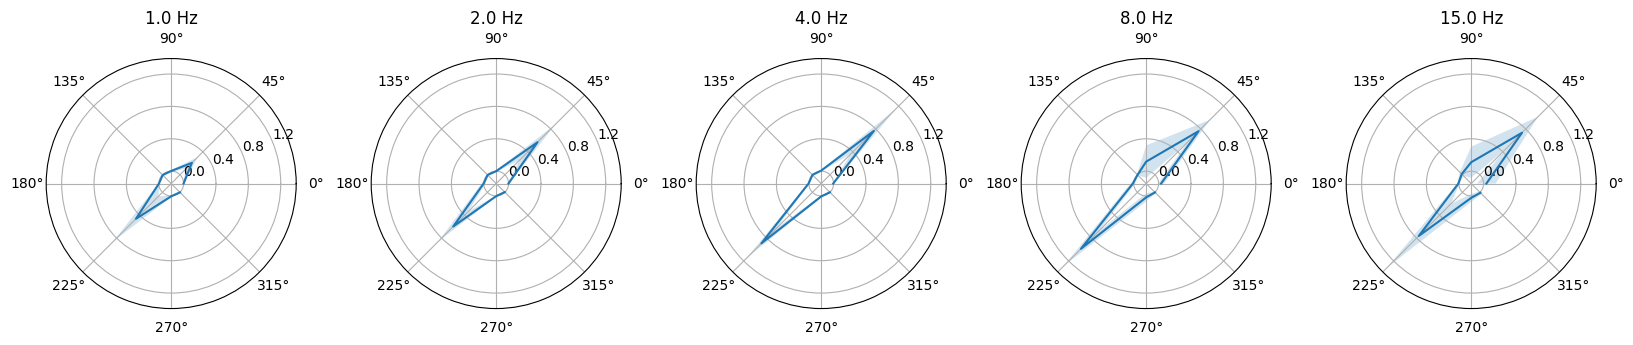

In [19]:
# plot a polar plot for for each orientation and temporal frequency
fig, axs = plt.subplots(
    1, 5, subplot_kw={"projection": "polar"}, figsize=(20, 10), sharey=True
)
plt.subplots_adjust(wspace=0.3)
for i, ax in enumerate(axs.flat):
    ax.plot(
        np.deg2rad(
            np.sort(
                data["stim_table"]["orientation"].unique()[
                    ~np.isnan(data["stim_table"]["orientation"].unique())
                ]
            )
        ),
        mean_calcium_orientation[10, :, i],
    )
    # add std to the plot
    ax.fill_between(
        np.deg2rad(
            np.sort(
                data["stim_table"]["orientation"].unique()[
                    ~np.isnan(data["stim_table"]["orientation"].unique())
                ]
            )
        ),
        mean_calcium_orientation[10, :, i] - std_calcium_orientation[10, :, i],
        mean_calcium_orientation[10, :, i] + std_calcium_orientation[10, :, i],
        alpha=0.2,
    )
    ax.set_title(f"{temporal_frequencies[i]} Hz")
    ax.set_yticks(np.arange(0, 1.5, 0.4))

# 2. Transforming the calcium traces to spikes
* only transform the traces where the drifting gratings were shown
* use the algorithm from coding lab 3 the OASIS algorithm, or trying out py-oopsi

In [20]:
# check if spike data is already saved
if os.path.exists("../data/spike_data.npy"):
    spike_data = np.load("../data/spike_data.npy")
else:
    spike_data = np.zeros((data["dff"].shape[0], data["dff"].shape[1]))
    for roi in range(data["dff"].shape[0]):
        # initialize the paraparameters for the oopsi algorithm
        F, P = ops.oopsi_init_par(data["dff"][roi], 1 / 30)
        n, C, post = ops.oopsi_est_map(F, P)
        print(n.shape)
        print(roi)
        spike_data[roi] = n
    np.save("../data/spike_data.npy", spike_data)

## Spike data was thresholded

In [21]:
# thershold the spike data at get the time points where the spike occurs
spike_data[spike_data < 0.2] = 0
spike_data[spike_data >= 0.2] = 1
spike_data = spike_data.astype(int)
spike_times = []
for roi in range(spike_data.shape[0]):
    spike_times.append(data["t"][spike_data[roi, :] >= 0.5])
spike_times = np.array(spike_times, dtype=object)

In [48]:
orientations = np.sort(data["stim_table"]["orientation"].unique())
colors_orentation = np.zeros(len(data["stim_table"]["orientation"]), dtype=int)
for i, ori in enumerate(orientations):
    if i == 8:
        colors_orentation[data["stim_table"]["blank_sweep"] == 1] = i
    colors_orentation[data["stim_table"]["orientation"] == ori] = i

rois = [10, 29, 54, 40]

fig, axs = plt.subplots(len(rois), figsize=(20, 20), sharex=True)
plt.subplots_adjust(hspace=0.3)

limits = [280, 350]
for i, roi in enumerate(rois):
    axs[i].plot(data["t"], data["dff"][roi], c="k")
    axs[i].scatter(
        spike_times[roi],
        np.ones(len(spike_times[roi])) * np.max(data["dff"][roi]) + 0.01,
        c="k",
        marker="|",
        s=200,
        zorder=10,
    )
    for indx, (s, e) in enumerate(
        zip(
            data["t"][np.array(data["stim_table"]["start"], dtype=int)],
            data["t"][np.array(data["stim_table"]["end"], dtype=int)],
        )
    ):
        axs[i].axvspan(
            s,
            e,
            alpha=0.6,
            color=colors_list[colors_orentation[indx]],
        )
    orientation_patches = [
        mp.Rectangle(
            (0, 0),
            1,
            1,
            fc=colors_list[i],
            alpha=0.6,
            angle=orientations[i],
        )
        for i in range(9)
    ]

    axs[i].set_xlim(limits)
    axs[i].set_title(f"ROI {roi}")
axs[i].set_xlabel("Time (s)")
fig.supylabel("dF/F", x=0.1, y=0.5)

axs[0].legend(
    orientation_patches,
    orientations,
    bbox_to_anchor=(0.2, 1.2),
    loc="center left",
    borderaxespad=-3,
    fontsize=12,
    title="Orientation \n (degrees)",
    title_fontsize=12,
    ncol=9,
)

In [23]:
# mean calcium value for each orientation
# get the spike times for each orientation
orientations = data["stim_table"]["orientation"].unique()
orientations = orientations[~np.isnan(orientations)]
mean_spike_orientation = np.zeros((data["dff"].shape[0], len(orientations)))
std_spike_orientation = np.zeros((data["dff"].shape[0], len(orientations)))

for i, orientation in enumerate(np.sort(orientations)):
    start_times = (
        data["stim_table"]["start"][data["stim_table"]["orientation"] == orientation]
        .to_numpy()
        .astype(int)
    )
    end_times = (
        data["stim_table"]["end"][data["stim_table"]["orientation"] == orientation]
        .to_numpy()
        .astype(int)
    )
    for roi in range(data["dff"].shape[0]):
        mean_spike_orientation[roi, i] = np.mean(
            [np.sum(spike_data[roi][s:e]) for s, e in zip(start_times, end_times)],
            axis=0,
        )
        std_spike_orientation[roi, i] = np.std(
            [np.sum(spike_data[roi][s:e]) for s, e in zip(start_times, end_times)],
            axis=0,
        )

Text(0.5, 1.0, 'ROI 10')

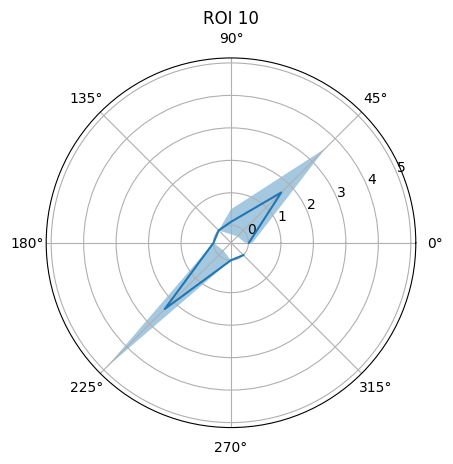

In [39]:
# plot a polar plot for for each orientation
roi = 10
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": "polar"})
ax.plot(
    np.deg2rad(
        np.sort(
            data["stim_table"]["orientation"].unique()[
                ~np.isnan(data["stim_table"]["orientation"].unique())
            ]
        )
    ),
    mean_spike_orientation[roi, :],
)
# add std to the plot
ax.fill_between(
    np.deg2rad(
        np.sort(
            data["stim_table"]["orientation"].unique()[
                ~np.isnan(data["stim_table"]["orientation"].unique())
            ]
        )
    ),
    mean_spike_orientation[roi, :] - std_spike_orientation[roi, :],
    mean_spike_orientation[roi, :] + std_spike_orientation[roi, :],
    alpha=0.4,
)
ax.set_title(f"ROI {roi}")

In [25]:
# mean calcium value for each orientation
orientations = data["stim_table"]["orientation"].unique()
orientations = np.sort(orientations[~np.isnan(orientations)])
temporal_frequencies = data["stim_table"]["temporal_frequency"].unique()
temporal_frequencies = np.sort(temporal_frequencies[~np.isnan(temporal_frequencies)])

mean_spike_orientation_freq = np.zeros(
    (data["dff"].shape[0], len(orientations), len(temporal_frequencies))
)
std_spike_orientation_freq = np.zeros(
    (data["dff"].shape[0], len(orientations), len(temporal_frequencies))
)
for i, orientation in enumerate(orientations):
    for j, freq in enumerate(temporal_frequencies):
        start_times = (
            data["stim_table"]["start"][
                (data["stim_table"]["orientation"] == orientation)
                & (data["stim_table"]["temporal_frequency"] == freq)
            ]
            .to_numpy()
            .astype(int)
        )
        end_times = (
            data["stim_table"]["end"][
                (data["stim_table"]["orientation"] == orientation)
                & (data["stim_table"]["temporal_frequency"] == freq)
            ]
            .to_numpy()
            .astype(int)
        )
        for roi in range(data["dff"].shape[0]):
            mean_spike_orientation_freq[roi, i, j] = np.mean(
                [np.sum(spike_data[roi][s:e]) for s, e in zip(start_times, end_times)],
                axis=0,
            )
            std_spike_orientation_freq[roi, i, j] = np.std(
                [np.sum(spike_data[roi][s:e]) for s, e in zip(start_times, end_times)],
                axis=0,
            )

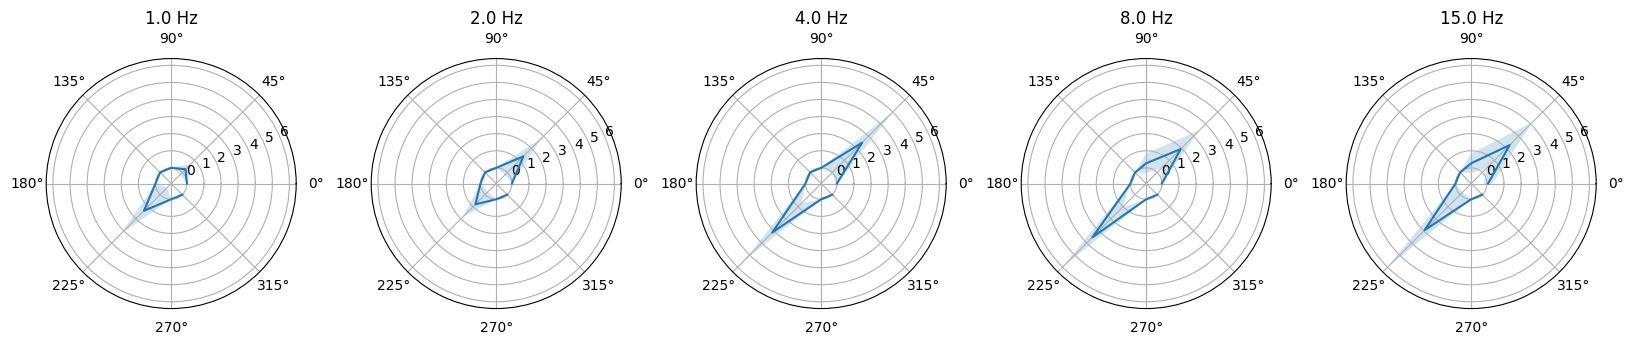

In [26]:
fig, axs = plt.subplots(
    1, 5, subplot_kw={"projection": "polar"}, figsize=(20, 10), sharey=True
)
plt.subplots_adjust(wspace=0.3)
for i, ax in enumerate(axs.flat):
    ax.plot(
        np.deg2rad(
            np.sort(
                data["stim_table"]["orientation"].unique()[
                    ~np.isnan(data["stim_table"]["orientation"].unique())
                ]
            )
        ),
        mean_spike_orientation_freq[10, :, i],
    )
    # add std to the plot
    ax.fill_between(
        np.deg2rad(
            np.sort(
                data["stim_table"]["orientation"].unique()[
                    ~np.isnan(data["stim_table"]["orientation"].unique())
                ]
            )
        ),
        mean_spike_orientation_freq[10, :, i] - std_spike_orientation_freq[10, :, i],
        mean_spike_orientation_freq[10, :, i] + std_spike_orientation_freq[10, :, i],
        alpha=0.2,
    )
    ax.set_title(f"{temporal_frequencies[i]} Hz")

# Choosing direction selective cells with permutation test
### explain assumptions
### exclude cells with activity outside the stimulus presentation
### exclude 29, 40, 48

In [177]:
idx_spikes = np.where(spike_data[29] == 1)[0]
print(idx_spikes)
start_times_inbetween = data["stim_table"]["end"].to_numpy().astype(int)
end_times_inbetween = data["stim_table"]["start"].to_numpy().astype(int)[1:]
for s, e in zip(start_times_inbetween, end_times_inbetween):
    if np.any((idx_spikes >= s) & (idx_spikes <= e)):
        print("spike inbetween")

[   307    365    366    367    394    395    396    454    455    456
    457    458    459    460    461    471    704    705    706    707
    708    831    832    833    834   2150   2151   2162   2163   2164
   2165   2166   2167   2812   2813   2814   2815   2816   2817   2818
   2819   3182   4031   4071   4224   4225   4226   4236   5345   5420
   5529   6152   6153   6154   7057   9175   9176   9177   9178  11669
  11876  12107  12124  12696  12703  12704  13295  13312  13313  13314
  13651  13655  13656  13657  13658  13792  15000  15405  15406  16811
  16812  16813  16814  19629  19630  19631  19632  19778  19779  19780
  19781  19782  20043  20044  20045  20046  20049  20050  20051  20055
  20056  20058  20095  20096  21230  21231  21306  21307  21313  21314
  21937  21938  21939  21940  21941  21942  21943  21945  22066  22068
  22089  22090  22091  22429  22430  22756  22757  22758  22759  22760
  22761  22762  25711  26472  27163  27194  27201  27202  27203  27224
  2722

In [179]:
rois_qualify = np.sum(spike_data, axis=1) > 0
qualifying_rois = np.where(rois_qualify)[0]
# exclude rois that fire inbetween the stimulus
counts_inbetween = np.zeros(data["dff"].shape[0], dtype=object)
start_times_inbetween = data["stim_table"]["end"].to_numpy().astype(int)
end_times_inbetween = data["stim_table"]["start"].to_numpy().astype(int)[1:]
for roi in qualifying_rois:
    idx_spikes = np.where(spike_data[roi] == 1)[0]
    counts_inbetween_roi = []
    for i, (s, e) in enumerate(zip(start_times_inbetween, end_times_inbetween)):
        ori = data["stim_table"]["orientation"][i]
        if np.isnan(ori):
            continue
        counts_inbetween_roi.append(np.sum((idx_spikes >= s) & (idx_spikes <= e)))
    counts_inbetween[roi] = np.sum(np.array(counts_inbetween_roi))

In [180]:
print(np.shape(counts_inbetween))
qualifying_rois_snr = []
for i, roi in enumerate(counts_inbetween):
    dirs, counts = utils.get_spike_counts_per_orientation(data, spike_data, i)
    if roi < np.sum(counts):
        qualifying_rois_snr.append(i)
print(qualifying_rois_snr)

(106,)
[5, 10, 11, 17, 19, 27, 33, 42, 46, 50, 51, 52, 54, 55, 70, 77, 84, 91, 97, 102]


In [181]:
# orientation selctivity to rois that have at leat 5 trials where the neuron fired for one orientation
p_dirs = np.ones(data["dff"].shape[0], dtype=float)
rois_qualify = np.sum(spike_data, axis=1) > 0
qualifying_rois = np.where(rois_qualify)[0]
qualifiying_rois = np.array(qualifying_rois_snr)
# bring qualifying_rois and qualifiying_rois in the same order
qualifying_rois = np.array([roi for roi in qualifying_rois if roi in qualifiying_rois])
for roi in qualifying_rois:
    dirs, counts = utils.get_spike_counts_per_orientation(data, spike_data, roi)
    counts_direction_unique = [
        len(np.where(counts[dirs == d] > 0)[0]) for d in np.unique(dirs)
    ]
    empty_check = np.array(counts_direction_unique) >= 5
    if np.sum(empty_check) > 0:
        p_dirs[roi] = utils.testTuning(counts, dirs, psi=1, niters=1000, show=False)[0]
    else:
        p_dirs[roi] = 1.0
idx = np.where(p_dirs < 0.01)[0]
print(idx)
rois = idx

[ 10  11  19  33  42  46  50  51  54  55  70  77  84  91  97 102]


In [153]:
for roi in rois:
    dirs, counts = utils.get_spike_counts_per_orientation(data, spike_data, roi)
    utils.testTuning(
        counts, dirs, psi=1, niters=1000, show=True, title_name=f"ROI {roi}"
    )

In [154]:
orientations = np.sort(data["stim_table"]["orientation"].unique())
colors_orentation = np.zeros(len(data["stim_table"]["orientation"]), dtype=int)
for i, ori in enumerate(orientations):
    if i == 8:
        colors_orentation[data["stim_table"]["blank_sweep"] == 1] = i
    colors_orentation[data["stim_table"]["orientation"] == ori] = i

rois = idx

plt.subplots_adjust(hspace=0.3)

limits = [0, 300]
for i, roi in enumerate(rois):
    fig, axs = plt.subplots(figsize=(20, 10), sharex=True)
    axs.plot(data["t"], data["dff"][roi], c="k")
    for indx, (s, e) in enumerate(
        zip(
            data["t"][np.array(data["stim_table"]["start"], dtype=int)],
            data["t"][np.array(data["stim_table"]["end"], dtype=int)],
        )
    ):
        axs.axvspan(
            s,
            e,
            alpha=0.6,
            color=colors_list[colors_orentation[indx]],
        )
    orientation_patches = [
        mp.Rectangle(
            (0, 0),
            1,
            1,
            fc=colors_list[i],
            alpha=0.6,
            angle=orientations[i],
        )
        for i in range(9)
    ]

    axs.set_xlim(limits)
    axs.set_title(f"ROI {roi}")


# axs.legend(
#     orientation_patches,
#     orientations,
#     bbox_to_anchor=(1.05, 2.5),
#     loc="center left",
#     borderaxespad=-3,
#     fontsize=12,
#     title="Orientation \n (degrees)",
#     title_fontsize=12,
# )

In [155]:
# plot a polar plot for for each orientation
for roi in rois:
    fig, ax = plt.subplots(1, 1, subplot_kw={"projection": "polar"})
    ax.plot(
        np.deg2rad(
            np.sort(
                data["stim_table"]["orientation"].unique()[
                    ~np.isnan(data["stim_table"]["orientation"].unique())
                ]
            )
        ),
        mean_spike_orientation[roi, :],
    )
    # add std to the plot
    ax.fill_between(
        np.deg2rad(
            np.sort(
                data["stim_table"]["orientation"].unique()[
                    ~np.isnan(data["stim_table"]["orientation"].unique())
                ]
            )
        ),
        mean_spike_orientation[roi, :] - std_spike_orientation[roi, :],
        mean_spike_orientation[roi, :] + std_spike_orientation[roi, :],
        alpha=0.4,
    )
    ax.set_yticks(np.arange(0, 5, 1))
    ax.set_title(f"ROI {roi}")

/var/folders/6f/4s63gb612m185fbsprljhfmh0000gn/T/ipykernel_42763/2833321973.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 1, subplot_kw={"projection": "polar"})


## Plotting the direction selective rois

In [170]:
matrix = np.zeros((data["roi_masks"].shape[1], data["roi_masks"].shape[2]))
for roi in rois:
    x, y = np.where(data["roi_masks"][roi, :, :] != 0)
    matrix[x, y] = 1
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(matrix)

Colormap transparent: https://stackoverflow.com/questions/42481203/transparent-colormap-in-matplotlib

In [187]:
colors_list = [
    "#271f7f",
    "#009688",
    "#ffc107",
    "#f44336",
]

fig, ax = plt.subplots(figsize=(20, 10))
for roi in rois:
    # plot the roi mask as scatter plot
    x, y = np.where(data["roi_masks"][roi, :, :] != 0)
    maxima_orientation = np.argmax(mean_spike_orientation[roi, :])
    print(maxima_orientation)
    if maxima_orientation > 3:
        maxima_orientation = maxima_orientation - 4
        print(f"after: {maxima_orientation}")

    ax.scatter(x, y, s=10, c=colors_list[maxima_orientation], alpha=0.6)
    # invert the y axis

    ax.set_xlim(0, 512)
    ax.set_ylim(0, 512)

5
after: 1
6
after: 2
5
after: 1
2
0
6
after: 2
2
1
7
after: 3
0
4
after: 0
5
after: 1
5
after: 1
4
after: 0
4
after: 0
1


## Question

**Is there spatial structure in the preferred orientation/direction/spatial frequency?**

Implement all steps of the processing pipeline that are necessary to answer them. Think of: 
1. Pre-processing 
2. Spike inference 
3. Tuning function fitting 
3.5. Sort functions with zero entries, and little spikes out
4. Statistical testing. 
5. Temporal frequencies?
6. Do neighbouring cells share the same orientation?

It is sufficient to assess spatial structure visually. Bonus points for proper statistical assessment. Also bonus points if you focus on specific cell types.